In [1]:
import pyro
from pyro import distributions as dist
import pyro.distributions.constraints as constraints
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
import pyro.contrib.gp as gp
from sklearn.datasets import fetch_olivetti_faces
from tqdm.autonotebook import tqdm
from torch import nn
from torch.nn import Parameter
from pyro.nn.module import PyroParam
import numpy as np
from sklearn.decomposition import NMF


In [2]:
pyro.clear_param_store()

In [3]:
x_train, y_train = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=97)


In [4]:
Y = (x_train)*255
Y = Y.astype(int)
Y = torch.tensor(Y)



In [5]:
N_people = 10#len(np.unique(y_train))
model = NMF(n_components=N_people, init='random', random_state=0)
W = torch.tensor(model.fit_transform(Y)).type(torch.float)
F = torch.tensor(model.components_).type(torch.float)


/Users/luisfcd/opt/miniconda3/envs/nsf/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [6]:
idx = torch.linspace(-32, 32, 64, dtype=torch.float)
idx2 = torch.linspace(-32, 32, 24, dtype=torch.float)
X = torch.cartesian_prod(-idx, idx).flip(dims=[1])
X_mggp  = X.repeat(N_people, 1)
Xu = torch.cartesian_prod(-idx2, idx2).flip(dims=[1])
Xu_mggp = Xu.repeat(N_people, 1)
N = X.shape[0]
N_Xu = Xu.shape[0]

X_groups = torch.concatenate([i*torch.ones(N) for i in range(N_people)]).type(torch.LongTensor)
Xu_groups = torch.concatenate([i*torch.ones(N_Xu) for i in range(N_people)]).type(torch.LongTensor)

In [7]:
class LinearT(nn.Module):
    """Linear transform and transpose"""
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = nn.Linear(dim_in, dim_out, bias=False)

    def forward(self, x):
        return self.linear(x).T

In [8]:
class LinearExp(gp.Parameterized):
    def __init__(self, dim_in, dim_out, W_init=None):
        super(LinearExp, self).__init__()
        self.dim_in = dim_in

        if W_init is None:
            W_init = torch.rand(dim_out, dim_in)
        
        assert W_init.shape == torch.Size([dim_out, dim_in])
        

        self.W = PyroParam(W_init, constraint=constraints.positive)
    
    def forward(self, x):
        x = torch.exp(x)
        x = x.view(self.dim_in, -1)
        x = torch.matmul(self.W, x)
        return x

In [9]:
skernel = gp.kernels.RBF(2, variance=torch.tensor(1), lengthscale=torch.tensor(1))
Kxx = skernel.forward(X)
Kxx.view(-1)[::N+1] += 1e-4
Kxz = skernel.forward(X, Xu)
u_loc = torch.log(F+1e-2) @ (torch.inverse(Kxx) @ Kxz)

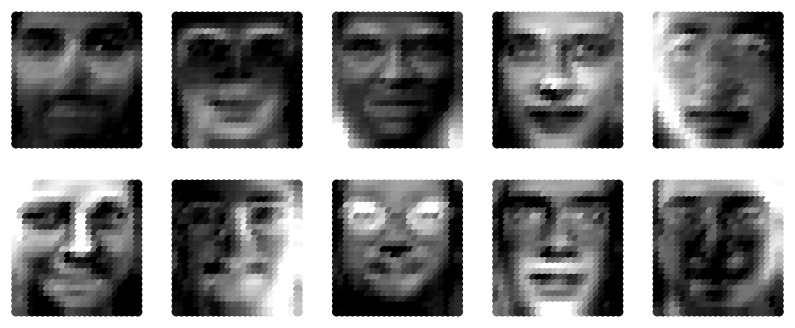

In [10]:
plt.figure(figsize=(10, N_people*2//5))
for i in range(N_people):
    plt.subplot(N_people//5, 5, i+1)
    loading = (u_loc[i].exp()).detach().cpu().numpy()
    plt.scatter(Xu[:, 0], Xu[:,1], c=loading, cmap='gray', vmin=0, vmax=10)

    plt.axis('off')

In [11]:
pyro.clear_param_store()
L = N_people
likelihood_mean = LinearExp(L, Y.shape[0], W_init=W)

likelihood = gp.likelihoods.Poisson(response_function=likelihood_mean)
mean_fn = LinearT(2, L)
kernel = gp.kernels.MultiGroupRBF(2, variance=torch.tensor(1.), lengthscale=torch.tensor(1))
gpr = gp.models.VariationalSparseMGGP(X_mggp, Y, kernel=kernel, groups=X_groups, Xu=Xu_mggp, Xu_groups= Xu_groups, likelihood=likelihood, latent_shape=torch.Size([]), jitter=1e-2, u_loc=u_loc.reshape(-1), nonGaussian=True)

In [12]:
Xu_mggp.shape

torch.Size([5760, 2])

In [13]:
X_mggp.shape

torch.Size([40960, 2])

In [14]:
optimizer = torch.optim.Adam(gpr.parameters(), lr=1e-3)
loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss

In [15]:
# do gradient steps
losses = []
for step in tqdm(range(200)):
    optimizer.zero_grad()
    # gpr.set_data(X_mggp, Y, nonGaussian=True)
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

  0%|          | 0/200 [00:00<?, ?it/s]

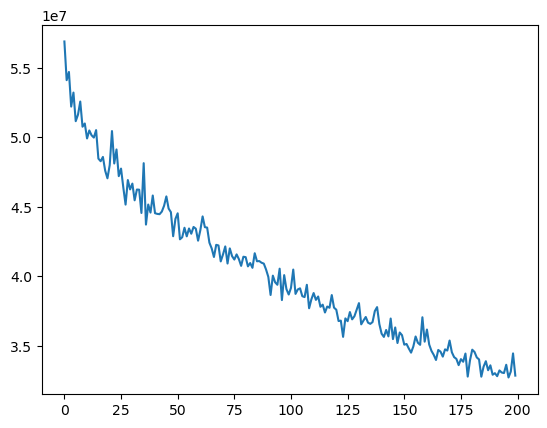

In [16]:
plt.plot(losses)

In [22]:
likelihood_mean.W

tensor([[ 8.9203,  5.4298,  4.5781,  ...,  8.1156,  0.0000,  4.4437],
        [ 5.5595,  3.6395,  5.5220,  ...,  1.2387,  1.6699,  0.0000],
        [ 3.1649,  3.6383,  5.1601,  ...,  3.0033,  3.9094,  5.3408],
        ...,
        [ 4.8989,  7.2508,  4.4351,  ...,  2.8419,  5.0099,  3.0677],
        [11.5194,  2.9206,  0.2168,  ...,  1.7517,  4.2195,  6.2012],
        [11.5482,  5.8461,  0.0000,  ...,  0.0000,  3.8419,  2.2569]],
       grad_fn=<AddBackward0>)

In [23]:
qF, _ = gpr.forward(X_mggp, X_groups)
Xtest = X_mggp.reshape(N_people, -1, X_mggp.shape[-1])
qF = qF.view(L, -1)

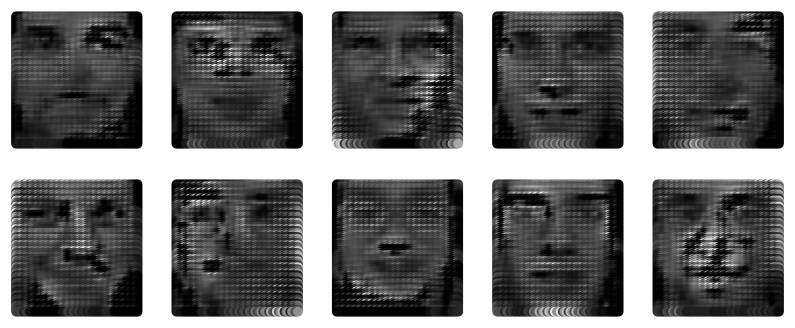

In [33]:
plt.figure(figsize=(10, N_people*2//5))
for i in range(N_people):
    plt.subplot(N_people//5, 5, i+1)
    loading = (qF[i].exp()).detach().cpu().numpy()
    plt.scatter(X[:, 0], X[:,1], c=loading, cmap='gray', vmin=0, vmax=10)

    plt.axis('off')